In [1]:
# %%
from generate_mdps import generate_datsets
from dataset import MDPDataset, AllNodeFeatures, InMemoryMDPDataset, TransitionsOnEdge
from experiment import Experiment
from MDP_helpers import calculate_gap, multiclass_recall_score

# %%
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import numpy as np

import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import GCN, GAT
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import random_split
from collections import defaultdict
from sklearn.metrics import recall_score, accuracy_score
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler

from time import time
from tqdm import tqdm

torch.cuda.manual_seed(12345)
np.random.seed(12345)

import pickle

/home/james/virtual_envs/csiro_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configs
experiment_name = "GAT_weighted_lr0001"
hparam_file = "hparams"
ascending = True
edge_attributes = False
gnn_model = GAT
pre_transform = TransitionsOnEdge()
lr = 0.0001
N_epochs = 3000
N_datasets = 100

N_sites = 6
N_species = 20
K = 8
N_states = 3**N_sites

dataset_folder = f"Reserve_MDP_{N_states}_{K}_1000"

training_configs = {
    "Re-create data": False,
    "N_trials": 5
}

filename = f'Reserve_MDP_{N_states}_{K}'

In [4]:
# Create experiment folder
experiment_exists = os.path.isfile(f"Results/{experiment_name}/{hparam_file}")
if not experiment_exists:
    raise Exception("Hparams do not yet exist!")

# Get device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using Device: {device}")

experiment = Experiment(savefile=f"Results/{experiment_name}/{hparam_file}")

print("Top 10 Hparams (including previous runs)")
hparams = pd.DataFrame(experiment.load()).sort_values(by="score", ascending=ascending).head()
print(hparams)

best_params = hparams.iloc[0].to_dict()

Using Device: cuda
Top 10 Hparams (including previous runs)
       score  hidden_channels  num_layers   dropout  weight_decay
49  0.501795            140.0         4.0  0.019882      0.001007
48  0.517946             21.0         3.0  0.052313      0.001054
47  0.529823             22.0         3.0  0.057117      0.001237
46  0.531904            175.0         4.0  0.033761      0.001167
45  0.533709             20.0         4.0  0.040401      0.001633


In [5]:
best_params

{'score': 0.5017945766448975,
 'hidden_channels': 140.0,
 'num_layers': 4.0,
 'dropout': 0.019881513008280383,
 'weight_decay': 0.0010067337214326756}

In [6]:
folder_exists = os.path.isdir(f"Results/{experiment_name}/{filename}")
if folder_exists:
    raise Exception("Folder exists: Experiment Exists Already!")
else:
    print("Creating experiment folder: Results/", experiment_name, "/", filename)
    os.mkdir(f"Results/{experiment_name}/{filename}")

print(f"MDP Data: N_states: {N_states}")
generate_datsets(N_sites, N_species, K, N_datasets, remove_previous=training_configs["Re-create data"], folder=dataset_folder)

print("Loading data into dataloader")
print(pre_transform)
dataset = InMemoryMDPDataset(f"datasets/{dataset_folder}", pre_transform=pre_transform)
print(dataset[0])
if torch.all(dataset[0].R == dataset[5].R):
    raise Exception("Datasets are likely identical!!")

Creating experiment folder: Results/ GAT_weighted_lr0001 / Reserve_MDP_729_8
MDP Data: N_states: 729
Creating folder  datasets/Reserve_MDP_729_8_1000/raw
Generating 100 MDPs with 729 states and 6 actions 



100%|██████████| 100/100 [02:05<00:00,  1.26s/it]


Loading data into dataloader
Data(x=[729, 12], edges=[2, 10176], edge_features=[10176, 6], k_labels=[729], P=[6, 729, 729], R=[729, 6], V=[729], starting_probability=0.9296160928171479, random_seed=0)


In [ ]:
# indices = np.arange(N_datasets)
# train_ids = indices[:80]
# test_ids = indices[80:]

In [7]:
all_results = defaultdict(lambda : defaultdict(list))
print(f"Starting K-fold cross validation using device {device}")
kfold = KFold(n_splits=training_configs["N_trials"], shuffle=True)
for trial_num, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
# trial_num = 0
# trial_name = "trial"
    train_sampler = SubsetRandomSampler(train_ids)
    test_sampler = SubsetRandomSampler(test_ids)

    train_data = DataLoader(dataset, batch_size=1, sampler=train_sampler)
    test_data = DataLoader(dataset, batch_size=1, sampler=test_sampler)

    trial_name = f"trial_{trial_num}"

    hidden_channels = int(best_params['hidden_channels'])
    num_layers = int(best_params['num_layers'])
    dropout = best_params['dropout']
    weight_decay = best_params['weight_decay']

    model = gnn_model(
        in_channels=dataset[0].x.shape[1], 
        out_channels=K, 
        hidden_channels=hidden_channels, 
        num_layers=num_layers, 
        dropout=dropout
    ).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    epochs = tqdm(range(N_epochs))
    for epoch in epochs:
        model.train()
        optimizer.zero_grad()     

        loss = 0
        for data in train_data:
            if edge_attributes:
                pred = model(
                    x = data.x.to(device), 
                    edge_index=data.edges.to(device), 
                    edge_attr=data.edge_features.to(device)
                )
            else:
                pred = model(
                    x = data.x.to(device), 
                    edge_index=data.edges.to(device), 
                )  
            weight = torch.bincount(data.k_labels)
            weight = weight/weight.sum()
            loss += F.cross_entropy(pred, data.k_labels.to(device), weight=weight.to(device))

        loss /= len(train_data) 
        loss.backward()
        optimizer.step()

        all_results[trial_name]['training_loss'].append(loss.to('cpu').detach().float())


        model.eval()
        test_loss = 0
        avg_gap = 0
        avg_error = 0
        avg_recall = 0
        avg_acc = 0
        for data in test_data:
            if edge_attributes:
                pred = model(
                    x = data.x.to(device), 
                    edge_index=data.edges.to(device), 
                    edge_attr=data.edge_features.to(device)
                )
            else:
                pred = model(
                    x = data.x.to(device), 
                    edge_index=data.edges.to(device), 
                )  
            pred_k = F.softmax(pred, dim=1).argmax(axis=1)
            weight = torch.bincount(data.k_labels)
            weight = weight/weight.sum()
            test_loss += F.cross_entropy(pred, data.k_labels.to(device), weight=weight.to(device))
            gap, error = calculate_gap(data.P, data.R, data.V, pred_k, K, device='cpu')
            avg_gap += gap
            avg_error += error
            avg_recall += recall_score(data.k_labels, pred_k.to('cpu'), average="macro")
            avg_acc += accuracy_score(data.k_labels, pred_k.to('cpu'))


        test_loss /= len(test_data)
        avg_gap /= len(test_data)
        avg_error /= len(test_data)
        avg_recall /= len(test_data)
        avg_acc /= len(test_data)

        all_results[trial_name]['test_loss'].append(test_loss.to('cpu').detach().float())
        all_results[trial_name]['test_gap'].append(avg_gap)
        all_results[trial_name]['test_error'].append(avg_error)
        all_results[trial_name]['test_recall'].append(avg_recall)
        all_results[trial_name]['test_accuracy'].append(avg_acc)

        epochs.set_description(f"Trial {trial_num}, Epoch {epoch+1}/{N_epochs}, Loss {test_loss:.4f}, Gap {avg_gap:.4f}, Recall {avg_recall:.4f}, Accuracy {avg_acc:.4f}")

    break

Starting K-fold cross validation using device cuda


  0%|          | 0/3000 [00:00<?, ?it/s]/home/james/Repo/MDP-State-Abstraction-CSIRO/Approach_new/state_variables/MDP_helpers.py:32: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  Q[:, a] = R[:, a].T + gamma*T[a, :, :]@V
Trial 0, Epoch 427/3000, Loss 0.8227, Gap 0.3050, Recall 0.4709, Accuracy 0.5853:  14%|█▍        | 427/3000 [11:54<1:11:46,  1.67s/it]


KeyboardInterrupt: 

In [ ]:
print("Saving Model")
file = open(f"Results/{experiment_name}/{filename}/model.pckl", "wb")
pickle.dump(model, file)
file.close()

Saving Model


Saving Data to files
Generating plots


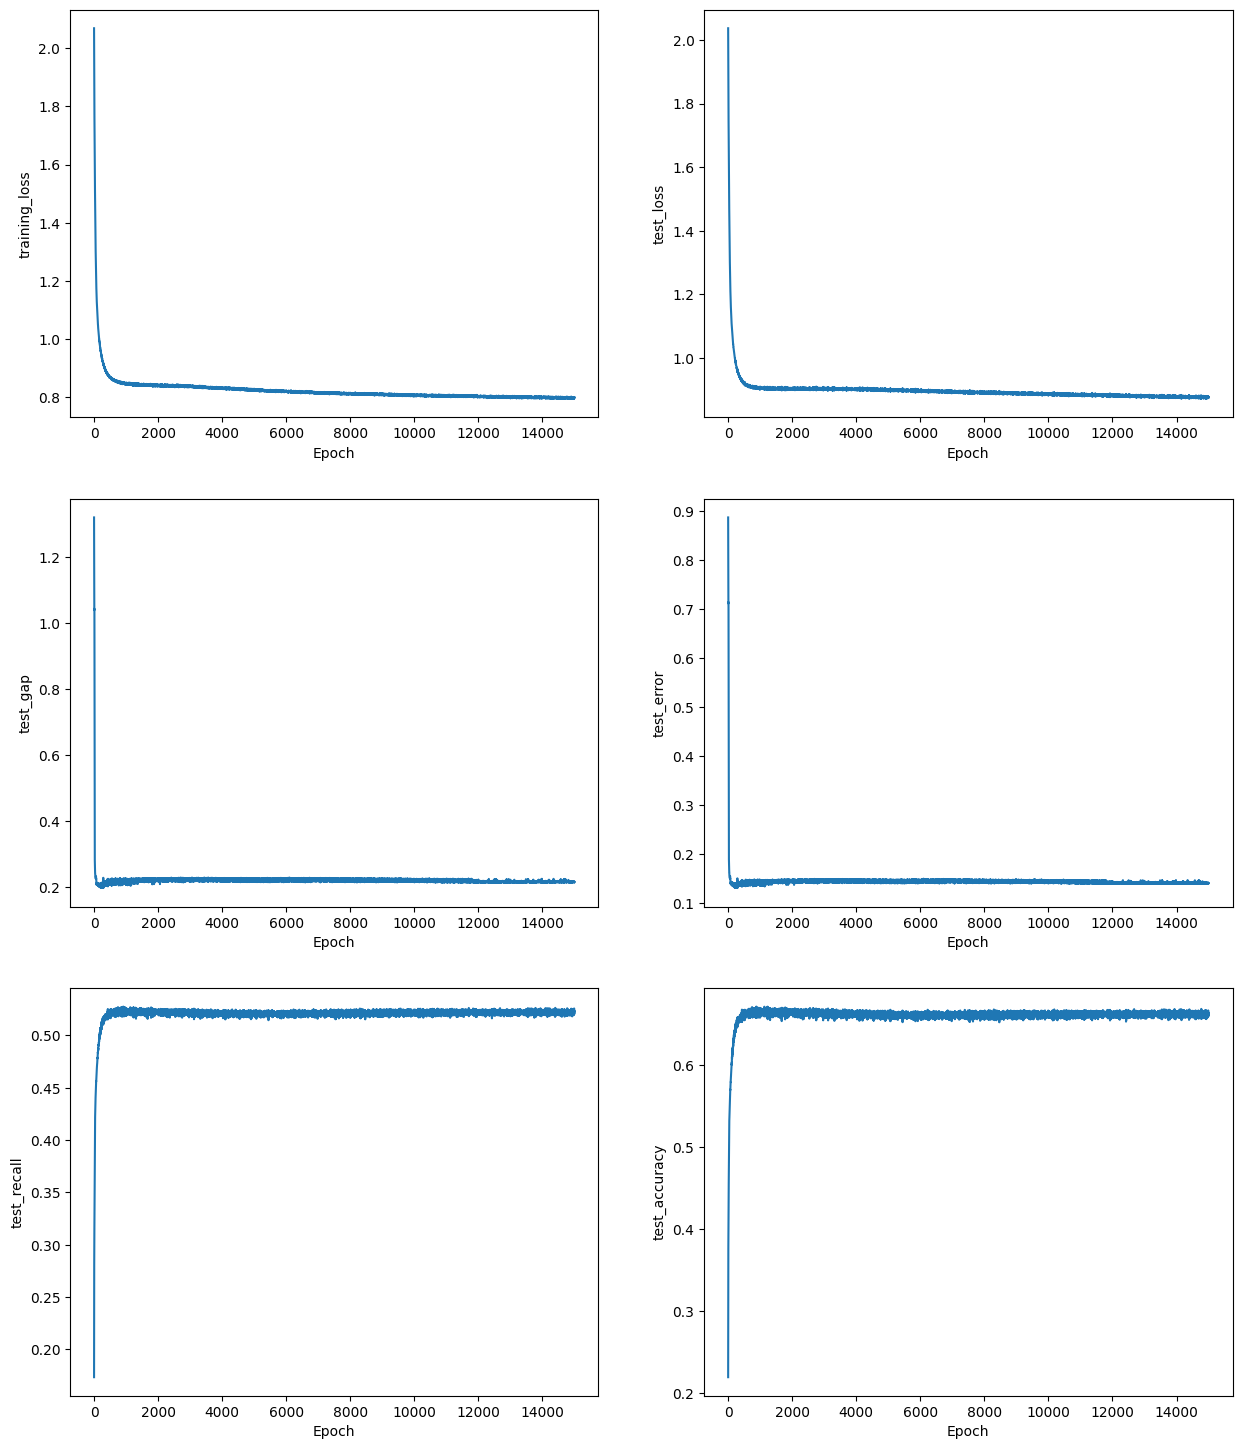

In [ ]:
print("Saving Data to files")
processed = {}
for key in all_results["trial_0"].keys():
    df = pd.DataFrame({trial_id:all_results[trial_id][key] for trial_id in all_results.keys()}).astype(float)
    df.to_csv(f"Results/{experiment_name}/{filename}/{key}.csv")
    processed[key] = df
print("Generating plots")
n_plots = len(all_results["trial_0"].keys())
n_cols = 2
n_rows = int((n_plots + n_plots%2)/2)

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 6*n_rows))

count = 0
for key in all_results["trial_0"].keys():
    col = count %2
    row = count //2 
    count += 1

    df_long = processed[key].stack()
    df_long.index = df_long.index.to_flat_index().map(lambda x: x[0])
    sns.lineplot(df_long, errorbar='ci', ax=ax[row, col])
    ax[row, col].set_ylabel(key)
    ax[row, col].set_xlabel("Epoch")

plt.savefig(f"Results/{experiment_name}/{filename}/plots.png")